# Finite Elements Lab 2 Worksheet

In [1]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

## 2d problem

We've looked at the problem of finding the static temperature distribution in a bar. Now let's move on to finding the temperature distribution of a plate of length $1$ on each side. The temperature $T(x, y) = T(x_1, x_2)$ satisfies

$$
  \nabla^2 T + f({\bf x}) = \left( \partial_{xx} + \partial_{yy} \right) T + f({\bf x}) = 0.
$$

We'll fix the temperature to be zero at the right edge, $T(1, y) = 0$. We'll allow heat to flow out of the other edges, giving the boundary conditions on all edges as

$$
\begin{align}
  \partial_x T(0, y) &= 0, & T(1, y) &=0, \\
  \partial_y T(x, 0) &= 0, & \partial_y T(x, 1) &=0.
\end{align}
$$

Once again we want to write down the weak form by integrating by parts. To do that we rely on the divergence theorem,

$$
  \int_{\Omega} \text{d}\Omega \, \nabla_i \phi = \int_{\Gamma} \text{d}\Gamma \, \phi n_i.
$$

Here $\Omega$ is the domain (which in our problem is the plate, $x, y \in [0, 1]$) and $\Gamma$ its boundary (in our problem the four lines $x=0, 1$ and $y=0, 1$), whilst ${\bf n}$ is the (inward-pointing) normal vector to the boundary.

We then multiply the strong form of the static heat equation by a *weight function* $w(x, y)$ and integrate by parts, using the divergence theorem, to remove the second derivative. To enforce the boundary conditions effectively we again choose the weight function to vanish where the value of the temperature is explicitly given, i.e. $w(1, y) = 0$. That is, we split the boundary $\Gamma$ into a piece $\Gamma_D$ where the boundary conditions are in Dirichlet form (the value $T$ is given) and a piece $\Gamma_N$ where the boundary conditions are in Neumann form (the value of the normal derivative $n_i \nabla_i T$ is given). We then enforce that on $\Gamma_D$ the weight function vanishes.

For our problem, this gives

$$
  \int_{\Omega} \text{d} \Omega \, \nabla_i w \nabla_i T = \int_{\Omega} \text{d} \Omega \, w f.
$$

Re-writing for our explicit domain and our Cartesian coordinates we get

$$
  \int_0^1 \text{d} y \, \int_0^1 \text{d} x \, \left( \partial_x w \partial_x T + \partial_y w \partial_y T \right) = \int_0^1 \text{d} y \, \int_0^1 \text{d} x \,  w(x, y) f(x, y).
$$

This should be compared to the one dimensional case

$$
  \int_0^1 \text{d}x \, \partial_x w(x) \partial_x T(x) = \int_0^1 \text{d}x \, w(x) f(x).
$$

We can now envisage using the same steps as the one dimensional case. Split the domain into elements, represent all functions in terms of known *shape functions* on each element, assemble the problems in each element to a single matrix problem, and then solve the matrix problem.

### Elements

Here we will use triangular elements. As a simple example we'll split the plate into two triangles.

In [2]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12,6)

In [3]:
nodes = numpy.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 1.0]])
IEN = numpy.array([[0, 1, 2], 
                   [1, 3, 2]])

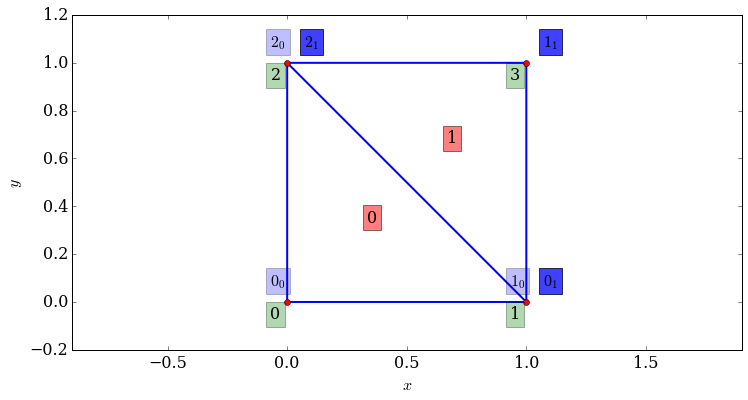

In [4]:
pyplot.figure()
pyplot.axis('equal')
pyplot.triplot(nodes[:,0], nodes[:,1], triangles=IEN, lw=2)
pyplot.plot(nodes[:,0], nodes[:,1], 'ro')
for e in range(nodes.shape[1]):
    barycentre = numpy.mean(nodes[IEN[e,:],:], axis=0)
    pyplot.text(barycentre[0], barycentre[1], "{}".format(e),
                bbox=dict(facecolor='red', alpha=0.5))
    for n in range(3):
        pyplot.text(nodes[IEN[e,n],0]-0.07*(-1)**e,nodes[IEN[e,n],1]+0.07, r"${}_{{{}}}$".format(n,e),
                    bbox=dict(facecolor='blue', alpha=0.25 + 0.5*e))
for n in range(nodes.shape[0]):
    pyplot.text(nodes[n,0]-0.07, nodes[n,1]-0.07, "{}".format(n),
                bbox=dict(facecolor='green', alpha=0.3))
pyplot.xlim(-0.2, 1.2)
pyplot.ylim(-0.2, 1.2)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$");

What we're doing here is

1. Providing a list of nodes by their global coordinates.
2. Providing the *element node array* `IEN` which says how the elements are linked to the nodes.

We have that for element $e$ and *local* node number $a = 0, 1, 2$ the global node number is $A = IEN(e, a)$. This notation is sufficiently conventional that `matplotlib` recognizes it with its `triplot`/`tripcolor`/`trisurf` functions.

It is convention that the nodes are ordered in the anti-clockwise direction as the local number goes from $0$ to $2$.

The plot shows the

* element numbers in the red boxes
* the *global* node numbers in the green boxes
* the *local* element numbers in the blue boxes (the subscript shows the element number).

We will need one final array, which is the $ID$ or *destination* array. This links the *global* node number to the *global* equation number in the final linear system. As the order of the equations in a linear system doesn't matter, this essentially encodes whether a node should have any equation in the linear system. Any node on $\Gamma_D$, where the value of the temperature is given, should not have an equation. In the example above the right edge is fixed, so nodes $1$ and $3$ lie on $\Gamma_D$ and should not have an equation. Thus in our case we have

In [5]:
ID = numpy.array([0,-1,1,-1])

In the one dimensional case we used the *location matrix* or $LM$ array to link local node numbers in elements to equations. With the $IED$ and $ID$ arrays the $LM$ matrix is strictly redundant, as $LM(a, e) = ID(IEN(e, a))$. However, it's still standard to construct it:

In [6]:
LM = numpy.zeros_like(IEN.T)
for e in range(IEN.shape[0]):
    for a in range(IEN.shape[1]):
        LM[a,e] = ID[IEN[e,a]]
LM

array([[ 0, -1],
       [-1, -1],
       [ 1,  1]])

### Function representation and shape functions

We're going to want to write our unknown functions $T, w$ in terms of shape functions. These are easiest to write down for a single reference element, in the same way as we did for the one dimensional case where our reference element used the coordinates $\xi$. In two dimensions we'll use the reference coordinates $\xi_0, \xi_1$, and the standard "unit" triangle:

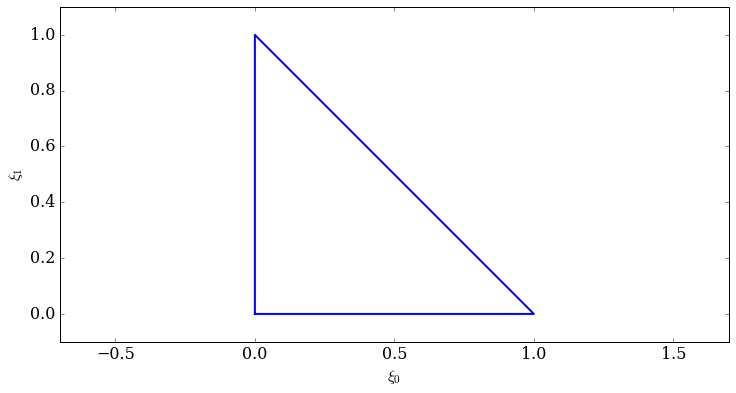

In [7]:
corners = numpy.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 0.0]])
pyplot.plot(corners[:,0],corners[:,1],linewidth=2)
pyplot.xlabel(r"$\xi_0$")
pyplot.ylabel(r"$\xi_1$")
pyplot.axis('equal')
pyplot.ylim(-0.1,1.1);

The shape functions on this triangle are

\begin{align}
  N_0(\xi_0, \xi_1) &= 1 - \xi_0 - \xi_1, \\
  N_1(\xi_0, \xi_1) &= \xi_0, \\
  N_2(\xi_0, \xi_1) &= \xi_1.
\end{align}

The derivatives are all either $0$ or $\pm 1$.

As soon as we have the shape functions, our weak form becomes

$$
  \sum_A T_A \int_{\Omega} \text{d}\Omega \, \left( \partial_{x} N_A (x, y) \partial_{x} N_B(x, y) + \partial_{y} N_A(x, y) \partial_{y} N_B(x, y) \right) = \int_{\Omega} \text{d}\Omega \, N_B(x, y) f(x, y).
$$

If we restrict to a single element the weak form becomes

$$
  \sum_A T_A \int_{\triangle} \text{d}\triangle \, \left( \partial_{x} N_A (x, y) \partial_{x} N_B(x, y) + \partial_{y} N_A(x, y) \partial_{y} N_B(x, y) \right) = \int_{\triangle} \text{d}\triangle \, N_B(x, y) f(x, y).
$$

We need to map the triangle and its $(x, y) = {\bf x}$ coordinates to the reference triangle and its $(\xi_0, \xi_1) = {\bf \xi}$ coordinates. We also need to work out the integrals that appear in the weak form. We need the transformation formula

$$
  \int_{\triangle} \text{d}\triangle \, \phi(x, y) = \int_0^1 \text{d}\xi_1 \, \int_0^{1-\xi_1} \text{d}\xi_0 \, \phi \left( x(\xi_0, \xi_1), y(\xi_0, \xi_1) \right) j(\xi_0, \xi_1),
$$

where the *Jacobian matrix* $J$ is

$$
  J = \left[ \frac{\partial {\bf x}}{\partial {\bf \xi}} \right] = \begin{pmatrix} \partial_{\xi_0} x & \partial_{\xi_1} x \\ \partial_{\xi_0} y & \partial_{\xi_1} y \end{pmatrix}
$$

and hence the *Jacobian determinant* $j$ is

$$
  j = \det{J} = \det \left[ \frac{\partial {\bf x}}{\partial {\bf \xi}} \right] = \det \begin{pmatrix} \partial_{\xi_0} x & \partial_{\xi_1} x \\ \partial_{\xi_0} y & \partial_{\xi_1} y \end{pmatrix}.
$$

We will also need the Jacobian matrix when writing the derivatives of the shape functions in terms of the coordinates on the reference triangle, i.e.

$$
  \begin{pmatrix} \partial_x N_A & \partial_y N_A \end{pmatrix} = \begin{pmatrix} \partial_{\xi_0} N_A & \partial_{\xi_1} N_A \end{pmatrix} J^{-1} .
$$

The integral over the reference triangle can be directly approximated using, for example, Gauss quadrature. To second order we have

$$
  \int_0^1 \text{d}\xi_1 \, \int_0^{1-\xi_1} \text{d}\xi_0 \, \psi \left( x(\xi_0, \xi_1), y(\xi_0, \xi_1) \right) \simeq \frac{1}{6} \sum_{j = 1}^{3} \psi \left( x((\xi_0)_j, (\xi_1)_j), y((\xi_0)_j, (\xi_1)_j) \right)
$$

where

$$
\begin{align}
  (\xi_0)_1 &= \frac{1}{6}, & (\xi_1)_1 &= \frac{1}{6}, \\
  (\xi_0)_2 &= \frac{4}{6}, & (\xi_1)_2 &= \frac{1}{6}, \\
  (\xi_0)_3 &= \frac{1}{6}, & (\xi_1)_3 &= \frac{4}{6}.
\end{align}
$$

Finally, we need to map from the coordinates ${\bf \xi}$ to the coordinates ${\bf x}$. This is straightforward if we think of writing each component $(x, y)$ in terms of the shape functions. So for element $e$ with node locations $(x^e_a, y^e_a)$ for local node number $a = 0, 1, 2$ we have

$$
\begin{align}
  x &= x^e_0 N_0(\xi_0, \xi_1) + x^e_1 N_1(\xi_0, \xi_1) + x^e_2 N_2(\xi_0, \xi_1), \\
  y &= y^e_0 N_0(\xi_0, \xi_1) + y^e_1 N_1(\xi_0, \xi_1) + y^e_2 N_2(\xi_0, \xi_1).
\end{align}
$$

### Tasks

1. Write a function that, given ${\bf \xi}$, returns that shape functions at that location.
2. Write a function that, given ${\bf \xi}$, returns the derivatives of the shape functions at that location.
3. Write a function that, given the (global) locations ${\bf x}$ of the nodes of a triangular element and the local coordinates ${\bf \xi}$ within the element returns the corresponding global coordinates.
5. Write a function that, given the (global) locations ${\bf x}$ of the nodes of a triangular element and the local coordinates ${\bf \xi}$, returns the Jacobian matrix at that location.
6. Write a function that, given the (global) locations ${\bf x}$ of the nodes of a triangular element and the local coordinates ${\bf \xi}$, returns the determinant of the Jacobian matrix at that location.
4. Write a function that, given the (global) locations ${\bf x}$ of the nodes of a triangular element and the local coordinates ${\bf \xi}$ within the element returns the derivatives $\partial_{\bf x} N_a = J^{-1} \partial_{\bf \xi} N_a$.
7. Write a function that, given a function $\psi({\bf \xi})$, returns the quadrature of $\psi$ over the reference triangle.
8. Write a function that, given the (global) locations of the nodes of a triangular element and a function $\phi(x, y)$, returns the quadrature of $\phi$ over the element.
9. Test all of the above by integrating simple functions (eg $1, \xi, \eta, x, y$) over the elements above.

### More tasks

1. Write a function to compute the coefficients of the stiffness matrix for a single element,
$$
  k^e_{ab} = \int_{\triangle^e}  \text{d}\triangle^e \, \left( \partial_{x} N_a (x, y) \partial_{x} N_b(x, y) + \partial_{y} N_a(x, y) \partial_{y} N_b(x, y) \right).
$$
2. Write a function to compute the coefficients of the force vector for a single element,
$$
  f^e_b = \int_{\triangle^e} \text{d}\triangle^e \, N_b(x, y) f(x, y).
$$

### Algorithm

This gives our full algorithm:

1. Set number of elements $N_{\text{elements}}$.
2. Set node locations ${\bf x}_A, A = 0, \dots, N_{\text{nodes}}$. Note that there is no longer a direct connection between the number of nodes and elements.
3. Set up the $IEN$ and $ID$ arrays linking elements to nodes and elements to equation numbers. From these set the location matrix $LM$. Work out the required number of equations $N_{\text{equations}}$ (the maximum of the $ID$ array plus $1$).
4. Set up arrays of zeros for the global stiffness matrix (size $N_{\text{equations}} \times N_{\text{equations}}$) and force vector (size $N_{\text{equations}}$).
5. For each element:

    1. Form the element stiffness matrix $k^e_{ab}$.
    2. Form the element force vector $f^e_a$.
    3. Add the contributions to the global stiffness matrix and force vector
    
6. Solve $K {\bf T} = {\bf F}$.

### Algorithm tasks

1. Write a function that given a list of nodes and the $IEN$ and $ID$ arrays and returns the solution ${\bf T}$.
2. Test on the system $f(x, y) = 1$ with exact solution $T = (1-x^2)/2$.
3. For a more complex case with the same boundary conditions try
$$
  f(x, y) = x^2 (x - 1) \left( y^2 + 4 y (y - 1) + (y - 1)^2 \right) + (3 x - 1) y^2 (y - 1)^2
$$
with exact solution
$$
  T(x, y) = \tfrac{1}{2} x^2 (1 - x) y^2 (1 - y)^2.
$$

A useful function is a grid generator or mesher. Good meshers are generally hard: here is a very simple one for this specific problem.

In [8]:
def generate_2d_grid(Nx):
    """
    Generate a triangular grid covering the plate math:`[0,1]^2` with Nx (pairs of) triangles in each dimension.
    
    Parameters
    ----------
    
    Nx : int
        Number of triangles in any one dimension (so the total number on the plate is math:`2 Nx^2`)
        
    Returns
    -------
    
    nodes : array of float
        Array of (x,y) coordinates of nodes
    IEN : array of int
        Array linking elements to nodes
    ID : array of int
        Array linking nodes to equations
    """
    Nnodes = Nx+1
    x = numpy.linspace(0, 1, Nnodes)
    y = numpy.linspace(0, 1, Nnodes)
    X, Y = numpy.meshgrid(x,y)
    nodes = numpy.zeros((Nnodes**2,2))
    nodes[:,0] = X.ravel()
    nodes[:,1] = Y.ravel()
    ID = numpy.zeros(len(nodes), dtype=numpy.int)
    n_eq = 0
    for nID in range(len(nodes)):
        if nID % Nnodes == Nx:
            ID[nID] = -1
        else:
            ID[nID] = n_eq
            n_eq += 1
    IEN = numpy.zeros((2*Nx**2,3), dtype=numpy.int)
    for i in range(Nx):
        for j in range(Nx):
            IEN[2*i+2*j*Nx  , :] = i+j*Nnodes, i+1+j*Nnodes, i+(j+1)*Nnodes
            IEN[2*i+1+2*j*Nx, :] = i+1+j*Nnodes, i+1+(j+1)*Nnodes, i+(j+1)*Nnodes
    return nodes, IEN, ID